In [1]:
from cryo_em_sbi import CryoEmSbi
import torch
import numpy as np
import matplotlib.pyplot as plt

import sbi
from tqdm import tqdm

# Introduction

In this tutorial I will show you how to generate synthetic images, preprocess them (apply ctf, noise, and shifts), and train a posterior probability function using SBI. I will also show how to check if the posterior trained work how it's intended to work.

## 1. The CryoEMSbi class

This class takes an input file (config_square.json) at sets up everything required to do SBI using CryoEM data 

In [2]:
cryosbi = CryoEmSbi("config_square.json")

## 2. Simulate

In this step we are going to generate synthetic cryoEM images based on the values on the config file. The images are generated from 20 discrete models, and each model has equal probability to be used. The indices and images are automatically saved as `indices.pt` and `images.pt`. You can change this names by passing your desired names to the function below.

If you want to use slurm to generate data, just launch `launch_gen_data.job` (Found in this same folder)

In [13]:
indices, images = cryosbi.simulate(num_workers=32)

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

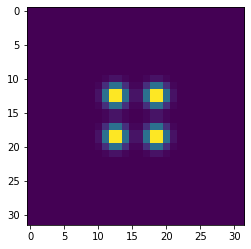

In [2]:
#Let's check how the images look
indices = torch.load("indices.pt")
images = torch.load("images.pt")

plt.imshow(images[1].reshape(32, 32))

# 3. Preprocessing
To properly simulate CryoEM we need to add noise, apply CTF effects, and shift the images randomly. We do not generate images directly with this effects, as it would be expensive to generate new datasets for each combination of effects. Instead we create raw images, and then apply a desired combination of filters before training.

The function below automatically saves indices and images as "indices_training.pt" and "images_training.pt".

Additionally, if you use a cpu to generate images, but a gpu to train the posterior, the function below automatically changes everything to the required device.

If you want to use slurm to run the preprocessing and the training just launch `launch_train_post_sbi_DEVICE.job`

In [5]:
indices_training, images_training = cryosbi.preprocess(indices, images)

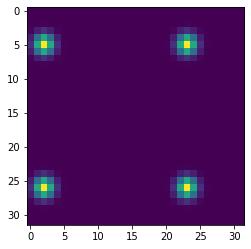

In [6]:
plt.imshow(images_training[350].reshape(32, 32))

# 4. Training the posterior

We use SBI to train the posterior. You can modify the type of model and the hyperparameters in the config file.

If you want to use slurm to run the preprocessing and the training just launch `launch_train_post_sbi_DEVICE.job`

In [7]:
posterior = cryosbi.train_posterior(num_workers=32)

/mnt/home/dsilvasanchez/virtual_envs/sbi_env_try/lib/python3.8/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 43 epochs.

If you already trained a network, or you trained it with slurm, you can load it with:

In [3]:
import pickle

with open(cryosbi.config["TRAINING"]["POSTERIOR_NAME"], "rb") as handle:
    posterior = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'posterior.pkl'

# 5. Checking if the posterior works

We can check that the posterior works by generating new images, and checking if it can pinpoint the model they were generated from.

In [ ]:
true_indices = torch.tensor(np.arange(0., 20., 1.).reshape(20, 1))
true_images = sbi.simulators.simutils.simulate_in_batches(cryosbi.simulator_analysis, true_indices, num_workers=1)

In [ ]:
plt.imshow(true_images[0].reshape(32, 32))

In [8]:
n_samples = 10000
samples = torch.zeros(20, n_samples, 1)

for i in range(20):
    
    samples[i] = posterior.sample((n_samples,), x=true_images[i], show_progress_bars=False)  

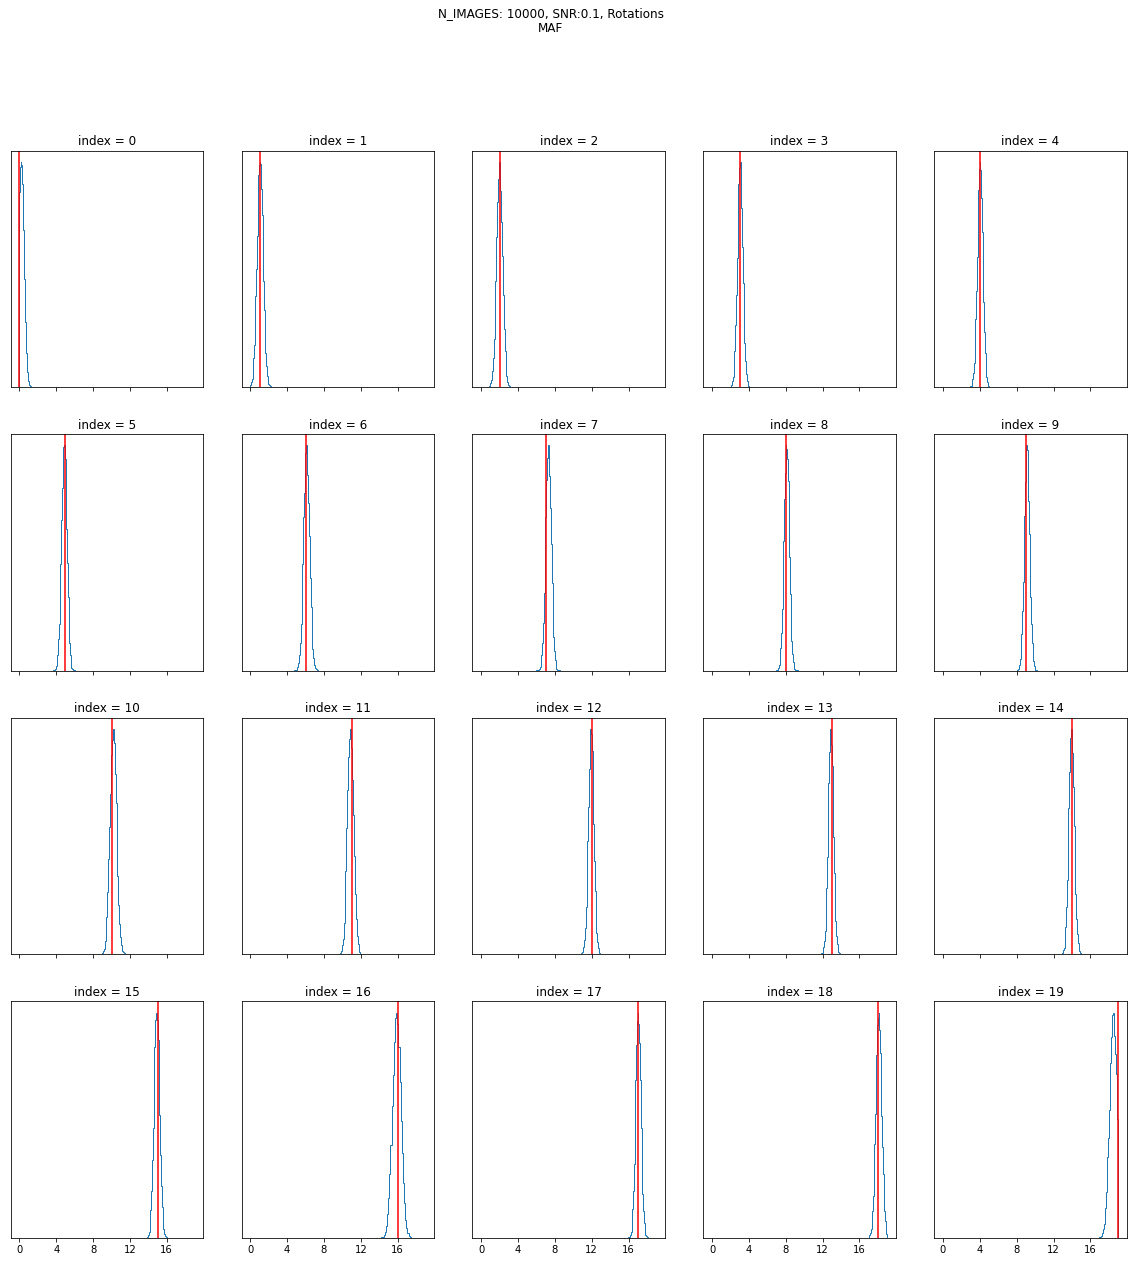

In [9]:
fig, axes = plt.subplots(4, 5, figsize=(20, 20), sharex=True)
fig.suptitle(f"N_IMAGES: {cryosbi.config['SIMULATION']['N_SIMULATIONS']}, SNR:{cryosbi.config['PREPROCESSING']['SNR']}, Rotations\nMAF")

for i in range(4):
    for j in range(5):

        axes[i,j].hist(samples[i*5 + j].numpy().flatten(), bins=30, histtype="step")
        axes[i,j].axvline(x=i*5 + j, color="red")
        axes[i,j].set_title(f"index = {i*5 + j}")
        axes[i,j].set_yticks([])
        axes[i,j].set_xticks(range(0, 19, 4))

# Recovering distributions

## Define your distribution

In [ ]:
# If you want to use an uniform distribution
true_indices =  cryosbi.prior_analysis.sample((5000,))

# Example for a 2-well distribution

"""
import torch.distributions as D

mix = D.Categorical(torch.ones(2,))
comp = D.Normal(torch.tensor([7., 14.]), torch.tensor([2., 2.]))
double_well_distribution = D.MixtureSameFamily(mix, comp)

true_indices = double_well_distribution.sample((5000,))

# Erase non-valid elementes (<0 or >19)

true_indices = torch.round(true_indices)

true_indices = true_indices[true_indices.round() <= 19.]
true_indices = true_indices[true_indices.round() >= 0]
"""

In [ ]:
num_workers = 8
batch_size = int(true_indices.shape[0] / num_workers)

true_images = sbi.simulators.simutils.simulate_in_batches(cryosbi.simulator_analysis, true_indices, num_workers=32)

In [ ]:
n_samples = 1000
samples = torch.zeros(true_indices.shape[0], n_samples, 1)

for i in tqdm(range(true_indices.shape[0])):
    samples[i] = posterior.sample((n_samples,), x=true_images[i], show_progress_bars=False)  

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(true_indices.numpy().flatten(), bins=np.arange(0, 20, 1), histtype="bar", rwidth=0.8);
ax[0].set_title("true distribution")

ax[1].hist(samples.numpy().flatten(), bins=np.arange(0, 20, 1), histtype="bar", rwidth=0.8);
ax[1].set_title("estimated distribution")

ax[0].set_xticks(np.arange(0, 20, 2));
ax[1].set_xticks(np.arange(0, 20, 2));